In [2]:
from astroquery.gaia import Gaia
from astropy.table import Table
from matplotlib.pyplot import subplots
from matplotlib import rcParams
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# Define Standard Units
fsize = 15
tsize = 18
tdir = 'in'
major = 5.0
minor = 3.0
style = 'default'


# Set all parameters for the plot
rcParams['text.usetex'] = False
rcParams['font.size'] = fsize
rcParams['legend.fontsize'] = tsize
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'times'
rcParams['xtick.direction'] = tdir
rcParams['ytick.direction'] = tdir
rcParams['xtick.major.size'] = major
rcParams['xtick.minor.size'] = minor
rcParams['ytick.major.size'] = major
rcParams['ytick.minor.size'] = minor

### Reading in Kepler/Gaia crossmatch data 

In [3]:
kepler_dr3_good = Table.read('kepler_dr3_good.fits', format='fits') # reading in crossmatch data
kepler_dr3_good_df = kepler_dr3_good.to_pandas() # creating a dataframe for later use
kepler_dr3_good_sourceids = kepler_dr3_good[['source_id', 'mh_gspphot']] # to be later uploaded to Gaia database

# since the original crossmatch used the gaia_source_lite table, there are some columns missing which I need
# for the calibration
# checking which parameters that we need (for callibration) are already in the table, and which are not.
parameters_for_callibration = [
    'teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'azero_gspphot', 'ebpminrp_gspphot', 'ag_gspphot', 
    'mg_gspphot', 'ra', 'dec', 'libname_gspphot'
]
required_parameters = []
unneeded_parameters = []

for i in parameters_for_callibration:
    if i in kepler_dr3_good.columns:
        unneeded_parameters += [i]
    else:
        required_parameters += [i]
        
print(f"The parameters we need that AREN'T currently in the dataframe are {', '.join(required_parameters)}")
print(f"The parameters we need that ARE already in the dataframe are {', '.join(unneeded_parameters)}")

The parameters we need that AREN'T currently in the dataframe are azero_gspphot, mg_gspphot, libname_gspphot
The parameters we need that are already in the dataframe are teff_gspphot, logg_gspphot, mh_gspphot, ebpminrp_gspphot, ag_gspphot, ra, dec


### Getting the parameters I need from the Gaia query system

In [4]:
# logging in to Gaia

username = 'cromines'
password = "6CPd@3Wp#3HGSk"
Gaia.login(user = username, password = password)

INFO: Login to gaia TAP server [astroquery.gaia.core]
OK
INFO: Login to gaia data server [astroquery.gaia.core]
OK


In [5]:
# uploading source ids to gaia (has already been uploaded)

# Gaia.upload_table(upload_resource = kepler_dr3_good_sourceids, table_name = "kepler_gaia_xmatch")

In [6]:
# Checking columns of my table

full_qualified_table_name = 'user_' + username + '.kepler_gaia_xmatch' # table must be referenced in this form
my_table = Gaia.load_table(full_qualified_table_name)

for column in my_table.columns:
    print(column.name)

Retrieving table 'user_cromines.kepler_gaia_xmatch'
kepler_gaia_xmatch_oid
source_id
mh_gspphot


In [7]:
# Building the query and running the job (~ 45 seconds)

gaia_source_params = "user.source_id, gaia.azero_gspphot, gaia.libname_gspphot, params.mg_gspphot"

adql_query = f"""
SELECT {gaia_source_params} 
FROM {full_qualified_table_name} AS user 
JOIN gaiadr3.gaia_source AS gaia 
ON gaia.source_id = user.source_id 
JOIN gaiadr3.astrophysical_parameters AS params 
ON params.source_id = user.source_id
"""    

job = Gaia.launch_job_async(adql_query)

# Convert the result to a Pandas DataFrame
results = job.get_results()
df_results = results.to_pandas()
df_results.head(3)

INFO: Query finished. [astroquery.utils.tap.core]


,source_id,azero_gspphot,libname_gspphot,mg_gspphot
0,2050233803028318080,NaN,,NaN
1,2050233601176543104,0.5364,MARCS,5.0881
2,2050230543159814656,0.0064,MARCS,0.3053


### Running the calibration and adding the calibrated metallicity back as a column

In [8]:
# getting all the required parameters for the calibration into one place
calibration_df = pd.merge(df_results, kepler_dr3_good.to_pandas(), on='source_id', how='inner')
calibration_df = calibration_df[[
    'source_id', 'teff_gspphot', 'logg_gspphot', 'mh_gspphot', 'azero_gspphot', 'ebpminrp_gspphot', 
    'ag_gspphot', 'mg_gspphot', 'libname_gspphot', 'ra', 'dec'
]]

# cleaning up the dataframe for the calibrations
clean_calibration_df = calibration_df.dropna(axis=0) # drop rows with NaN in them
clean_calibration_df = clean_calibration_df.reset_index(drop=True) # reset indexes
clean_calibration_df.head(3)

,source_id,teff_gspphot,logg_gspphot,mh_gspphot,azero_gspphot,ebpminrp_gspphot,ag_gspphot,mg_gspphot,libname_gspphot,ra,dec
0,2050233601176543104,5616.329590,4.4508,-0.3394,0.5364,0.2373,0.4400,5.0881,MARCS,291.043058,36.593767
1,2050230543159814656,4451.399902,2.1047,-0.3895,0.0064,0.0026,0.0049,0.3053,MARCS,291.055891,36.559885
2,2050231848829944320,5004.754395,4.4394,-0.1710,0.1634,0.0684,0.1295,5.5022,PHOENIX,291.137622,36.577344


In [9]:
from gdr3apcal import GaiaDR3_GSPPhot_cal # from github metallicity calibration tool
calib = GaiaDR3_GSPPhot_cal()
metal_calib = calib.calibrateMetallicity(clean_calibration_df) # calibrating metallicity

Automatically adding cos(b) from given ra and dec assuming degrees.
Automatically adding cos(b) from given ra and dec assuming degrees.
Automatically adding cos(b) from given ra and dec assuming degrees.
Automatically adding cos(b) from given ra and dec assuming degrees.


In [10]:
# adding the calibrated metallicities to the dataframe

clean_calibration_df['calibrated_FeH'] = metal_calib
clean_calibration_df = clean_calibration_df[['source_id', 'calibrated_FeH']]
clean_calibration_df.head(3)

,source_id,calibrated_FeH
0,2050233601176543104,-0.041918
1,2050230543159814656,-0.190046
2,2050231848829944320,0.428135


In [11]:
calibrated_kepler_dr3_good = pd.merge(clean_calibration_df, kepler_dr3_good.to_pandas(), on='source_id')
calibrated_kepler_dr3_good.to_csv('calibrated_kepler_dr3_good.csv', index=False) # saving the dataframe as a file
calibrated_kepler_dr3_good.head(3)

,source_id,calibrated_FeH,kepid,ra_kic,dec_kic,random_index,ra,dec,parallax,parallax_error,...,mass_err2,prov_sec,nconfp,nkoi,ntce,jmag,hmag,kmag,planet?,kepler_gaia_mag_diff
0,2050233601176543104,-0.041918,757099,291.04306,36.593811,187127310,291.043058,36.593767,2.798592,0.031155,...,-0.233,b'DSEP',0,0,1,11.656,11.193,11.094,b'none',-0.072974
1,2050230543159814656,-0.190046,757137,291.05588,36.559952,391020929,291.055891,36.559885,1.754854,0.010898,...,-0.947,b'DSEP',0,0,0,7.467,6.853,6.722,b'none',-0.063634
2,2050231848829944320,0.428135,757450,291.13760,36.577381,189196887,291.137622,36.577344,1.231338,0.020312,...,-0.040,b'DSEP',1,1,1,13.665,13.262,13.118,b'conf',-0.104204


### Comparing the calibrated data with the uncalibrated data

In [12]:
# Load dr25 exoplanet data
dr25 = pd.read_csv('mydata.csv', comment='#') # loading in csv of kepler dr25 from NASA exoplanet archive
dr25 = dr25.query('koi_disposition == "CONFIRMED" or koi_disposition == "CANDIDATE"')
dr25 = dr25[['kepid', 'koi_prad']]

dr25_cal = dr25[dr25['kepid'].isin(calibrated_kepler_dr3_good['kepid'])] # removing planets w/o calibrated FeH, 
dr25_cal = pd.merge(dr25_cal, calibrated_kepler_dr3_good, on='kepid')

planets_cal = dr25_cal[dr25_cal['koi_prad'].between(0.0, 4.0)] # filtering to (0 < R < 4)
planets_cal = planets_cal.drop_duplicates(subset='kepid', keep='first') # keeping only 1 count per star system

dr25_uncal = dr25[dr25['kepid'].isin(kepler_dr3_good_df['kepid'])] # removing planets not in original xmatch
dr25_uncal = pd.merge(dr25_uncal, kepler_dr3_good_df, on='kepid')
planets_uncal = dr25_uncal[dr25_uncal['koi_prad'].between(0.0, 4.0)] # filtering to (0 < R < 4)
planets_uncal = planets_uncal.drop_duplicates(subset='kepid', keep='first') # keeping only 1 count per star system

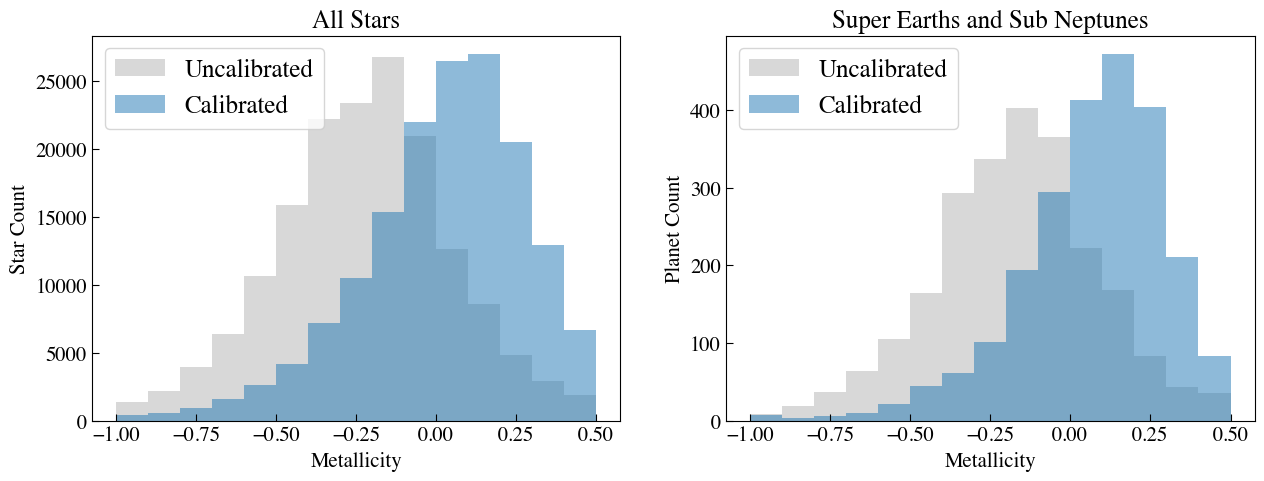

In [48]:
# plotting total stars and total superearth / sub-neptunes into histogram, comparing calibrated vs. uncalibrated
# note: calibrated data has ~30,000 less stars
min_metallicity = -1
max_metallicity = 0.6
bin_size = 0.1
bins = np.arange(min_metallicity, max_metallicity, bin_size)

fig, axes = subplots(nrows = 1,
                     ncols = 2,
                     figsize=(15,5))

axes[0].set_ylabel('Star Count')
axes[0].set_xlabel('Metallicity')
axes[0].set_title('All Stars')
n_stars_uncal, bins_stars_uncal, patches_stars_uncal = axes[0].hist(
    kepler_dr3_good_df['mh_gspphot'], 
    bins, 
    alpha=0.3, 
    color = 'gray', 
    label = 'Uncalibrated'
);
n_stars_cal, bins_stars_cal, patches_stars_cal = axes[0].hist(
    calibrated_kepler_dr3_good['calibrated_FeH'], 
    bins, 
    alpha=0.5, 
    label = 'Calibrated'
);
axes[0].legend()

axes[1].set_ylabel('Planet Count')
axes[1].set_xlabel('Metallicity')
axes[1].set_title('Super Earths and Sub Neptunes')
n_planets_uncal, bins_planets_uncal, patches_planets_uncal = axes[1].hist(
    planets_uncal['mh_gspphot'], 
    bins, 
    alpha=0.3, 
    color = 'gray', 
    label = 'Uncalibrated'
);
n_planets_cal, bins_planets_cal, patches_planets_cal = axes[1].hist(
    planets_cal['calibrated_FeH'], 
    bins, 
    alpha=0.5, 
    label = 'Calibrated'
);   
axes[1].legend();

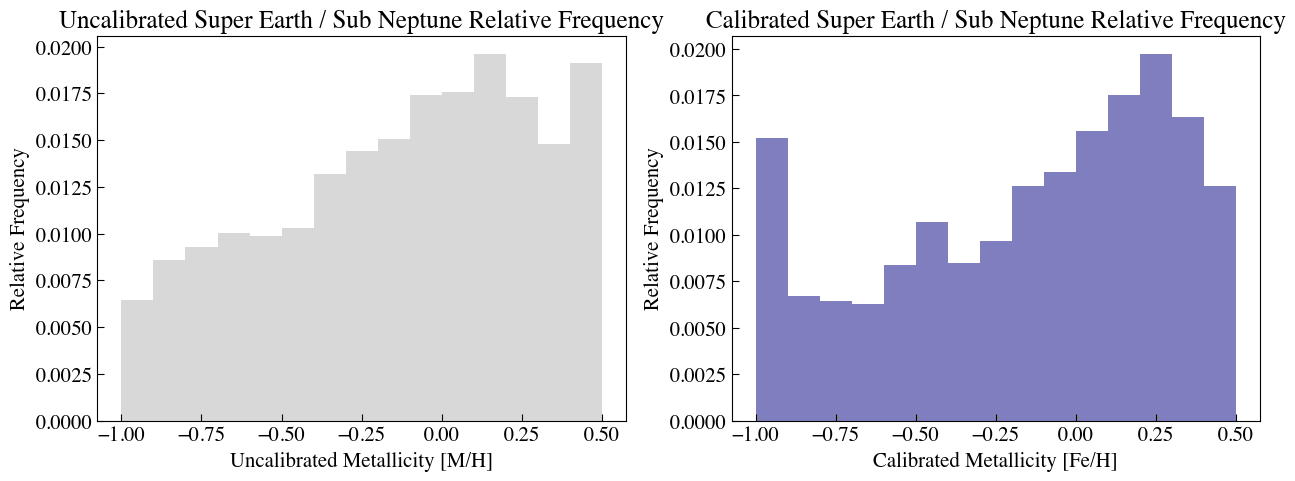

In [63]:
# plotting relative frequencies

uncalibrated_rel_freq = n_planets_uncal / n_stars_uncal
calibrated_rel_freq = n_planets_cal / n_stars_cal

fig, axes = subplots(nrows = 1, 
                     ncols = 2, 
                     figsize = (15, 5))

axes[0].set_ylabel('Relative Frequency')
axes[0].set_xlabel('Uncalibrated Metallicity [M/H]')
axes[0].set_title('Uncalibrated Super Earth / Sub Neptune Relative Frequency')
axes[0].hist(
    bins[:-1], 
    bins, 
    weights = uncalibrated_rel_freq, 
    alpha=0.3, 
    color='gray', 
);

axes[1].set_ylabel('Relative Frequency')
axes[1].set_xlabel('Calibrated Metallicity [Fe/H]')
axes[1].set_title('Calibrated Super Earth / Sub Neptune Relative Frequency')
axes[1].hist(
    bins[:-1], 
    bins, 
    weights = calibrated_rel_freq, 
    alpha=0.5, 
    color='navy', 
);

### Plotting the other radii ranges (just with Calibrated data)

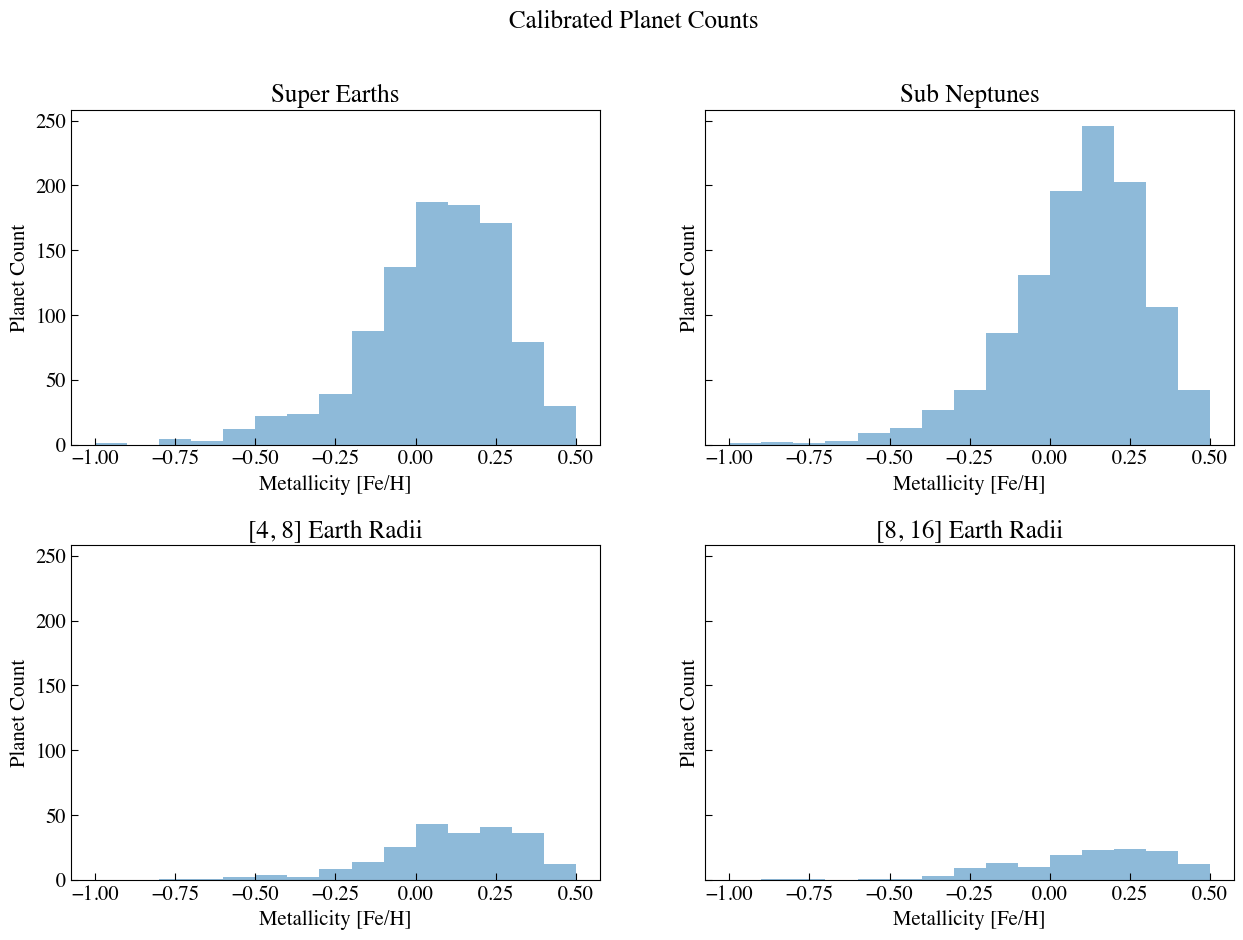

In [58]:
# plotting other possible radius ranges (just calibrated data)

super_earths = dr25_cal[dr25_cal['koi_prad'].between(1.2, 2.0)] # filtering to (1.2 < R < 2.0)
super_earths = super_earths.drop_duplicates(subset='kepid', keep='first') # keeping only 1 count per star system

sub_neptunes = dr25_cal[dr25_cal['koi_prad'].between(2.0, 4.0)] # filtering to (2.0 < R < 4.0)
sub_neptunes = sub_neptunes.drop_duplicates(subset='kepid', keep='first') # keeping only 1 count per star system

radius_4to8 = dr25_cal[dr25_cal['koi_prad'].between(4.0, 8.0)] # filtering to (4.0 < R < 8.0)
radius_4to8 = radius_4to8.drop_duplicates(subset='kepid', keep='first') # keeping only 1 count per star system

radius_8to16 = dr25_cal[dr25_cal['koi_prad'].between(8.0, 16.0)] # filtering to (8.0 < R < 16.0)
radius_8to16 = radius_8to16.drop_duplicates(subset='kepid', keep='first') # keeping only 1 count per star system

fig, axes = subplots(nrows = 2,
                     ncols = 2, 
                     sharey = True, 
                     figsize=(15,10))
fig.subplots_adjust(hspace=0.3) # creates more space between rows, prevents title and x-axis overlap
fig.suptitle('Calibrated Planet Counts')

axes[0,0].set_ylabel('Planet Count')
axes[0,0].set_xlabel('Metallicity [Fe/H]')
axes[0,0].set_title('Super Earths')
n_super_earths, bins_super_earths, patches_super_earths = axes[0,0].hist(
    super_earths['calibrated_FeH'], 
    bins, 
    alpha=0.5
);

axes[0,1].set_ylabel('Planet Count')
axes[0,1].set_xlabel('Metallicity [Fe/H]')
axes[0,1].set_title('Sub Neptunes')
n_sub_neptunes, bins_sub_neptunes, patches_sub_neptunes = axes[0,1].hist(
    sub_neptunes['calibrated_FeH'], 
    bins, 
    alpha=0.5
);

axes[1,0].set_ylabel('Planet Count')
axes[1,0].set_xlabel('Metallicity [Fe/H]')
axes[1,0].set_title('[4, 8] Earth Radii')
n_4to8, bins_4to8, patches_4to8 = axes[1,0].hist(
    radius_4to8['calibrated_FeH'], 
    bins, 
    alpha=0.5
);

axes[1,1].set_ylabel('Planet Count')
axes[1,1].set_xlabel('Metallicity [Fe/H]')
axes[1,1].set_title('[8, 16] Earth Radii')
n_8to16, bins_8to16, patches_8to16 = axes[1,1].hist(
    radius_8to16['calibrated_FeH'], 
    bins, 
    alpha=0.5
);

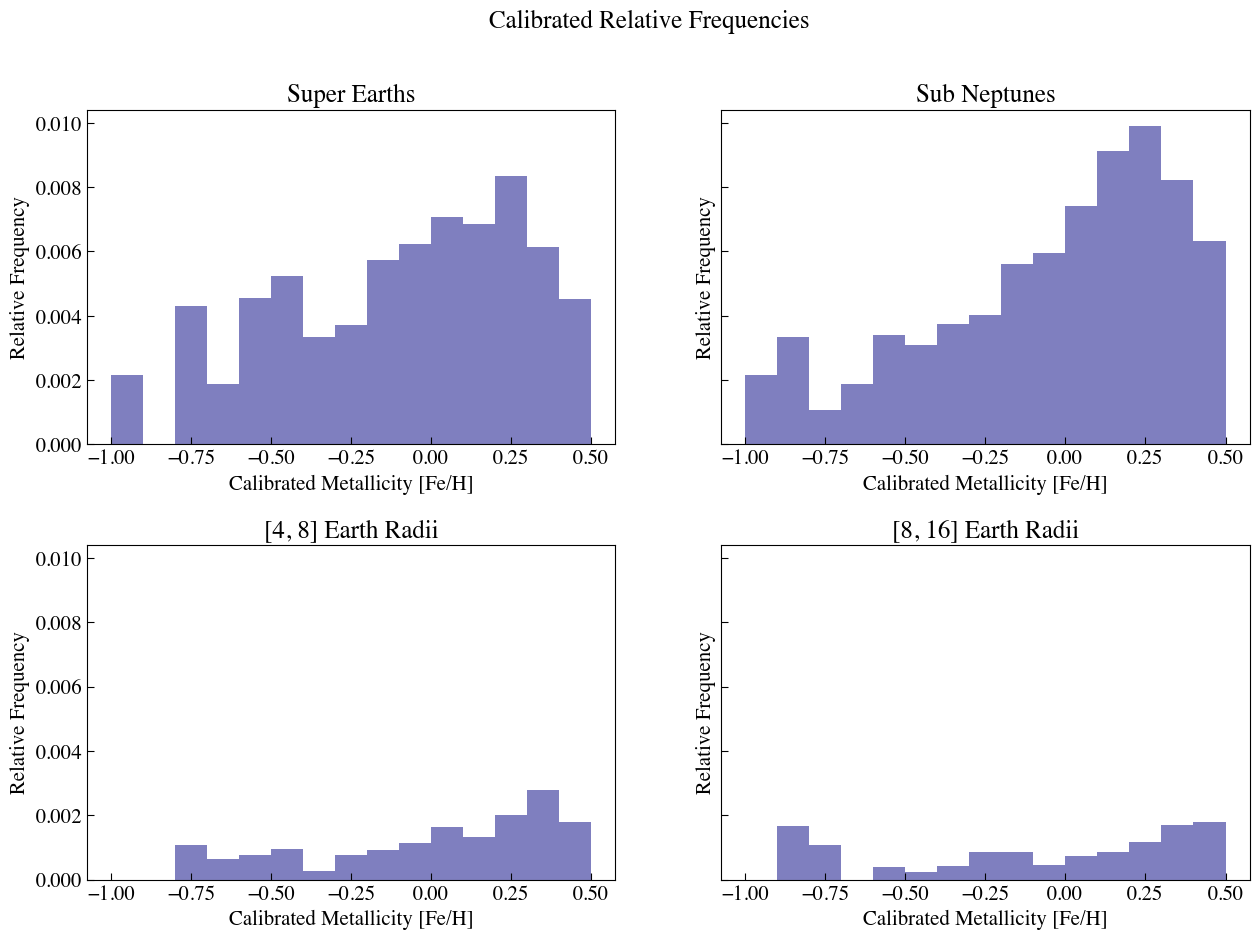

In [64]:
# plotting relative frequencies for other possible radius ranges

super_earth_rel_freq = n_super_earths / n_stars_cal
sub_neptune_rel_freq = n_sub_neptunes / n_stars_cal
radius_4to8_rel_freq = n_4to8 / n_stars_cal
radius_8to16_rel_freq = n_8to16 / n_stars_cal

fig, axes = subplots(nrows = 2,
                     ncols = 2, 
                     sharey = True, 
                     figsize=(15,10))
fig.subplots_adjust(hspace=0.3) # creates more space between rows, prevents title and x-axis overlap
fig.suptitle('Calibrated Relative Frequencies')

axes[0,0].set_ylabel('Relative Frequency')
axes[0,0].set_xlabel('Calibrated Metallicity [Fe/H]')
axes[0,0].set_title('Super Earths')
axes[0,0].hist(
    bins[:-1], 
    bins, 
    weights = super_earth_rel_freq, 
    color = 'navy', 
    alpha=0.5
);

axes[0,1].set_ylabel('Relative Frequency')
axes[0,1].set_xlabel('Calibrated Metallicity [Fe/H]')
axes[0,1].set_title('Sub Neptunes')
axes[0,1].hist(
    bins[:-1], 
    bins, 
    weights = sub_neptune_rel_freq, 
    color = 'navy', 
    alpha=0.5
);

axes[1,0].set_ylabel('Relative Frequency')
axes[1,0].set_xlabel('Calibrated Metallicity [Fe/H]')
axes[1,0].set_title('[4, 8] Earth Radii')
axes[1,0].hist(
    bins[:-1], 
    bins, 
    weights = radius_4to8_rel_freq, 
    color = 'navy', 
    alpha=0.5
);

axes[1,1].set_ylabel('Relative Frequency')
axes[1,1].set_xlabel('Calibrated Metallicity [Fe/H]')
axes[1,1].set_title('[8, 16] Earth Radii')
axes[1,1].hist(
    bins[:-1], 
    bins, 
    weights = radius_8to16_rel_freq, 
    color = 'navy', 
    alpha=0.5
);